In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid, cumulative_trapezoid
from multiprocessing import Pool
import multiprocessing as mp
import emcee
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Leitura dos dados FRB
# =========================

df_frb = pd.read_csv("/home/brunowesley/projetos/MCMC-cosmo/Data/FRB/frb_catalog.txt", sep=r"\t", engine='python')
df_frb = df_frb.sort_values(by="Redshift", ascending=True)
df_frb = df_frb.reset_index(drop=True)

z_frb   = df_frb["Redshift"].to_numpy(float)
DM_obs  = df_frb["DM_obs"].to_numpy(float)
DM_MW   = df_frb["DM_MW_ISM_(NE2001)"].to_numpy(float)

DM_halo_mean = 50
DM_MW_total = DM_MW + DM_halo_mean

DM_ext_obs = DM_obs - DM_MW_total

In [3]:
# =========================
# Fiducial
# =========================

# Priors uniformes
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
w_min, w_max = -3.0, 1.0
sig_host_min, sig_host_max = 0.2, 2.0
e_mu_min, e_mu_max = 20., 200.

# Prios gaussianos
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Constantes físicas
c_si = 2.99792458e8
G_si = 6.67430e-11
mp_si = 1.67262192369e-27

# Parâmetros cosmológicos/astrofísicos
Or0 = 7.88e-5
f_IGM = 0.83
chi_e = 0.875

# Grade
z_grid = np.linspace(0, 2.5, 1000)

In [4]:
# =========================
# DM_IGM(z)
# =========================

def DM_IGM_theory(z_frb, H0, Om0, Ob, w):

    # fator pré-integral
    A = 3 * c_si * f_IGM * chi_e / (8 * np.pi * G_si * mp_si) 
    
    # Função de Hubble (modelo wCDM plano)
    Om = Om0 * (1 + z_grid)**3
    Or = Or0 * (1 + z_grid)**4
    Ode0 = 1 - Om0 - Or0
    Ode = Ode0 * (1 + z_grid)**(3*(1 + w))
    E_grid = np.sqrt(Om + Or + Ode)
    
    # integrando e integral em DM_IGM
    integrand = (1 + z_grid) / E_grid
    I = cumulative_trapezoid(integrand, z_grid, initial=0.0)

    # DM_IGM (precisa converter as unidades)
    DM_IGM_prime = A * Ob * H0 * I

    # fatores de conversão
    km_to_pc = 1/(3.0857e13)
    m2_to_cm2 = 1e4
    Mpc_to_cm = 3.0857e24

    # DM_IGM nas unidades corretas (pc/cm³)
    DM_IGM_th = DM_IGM_prime * (km_to_pc / (m2_to_cm2 * Mpc_to_cm))

    # interpolação vetorizada
    DM_IGM_LCDM = np.interp(z_frb, z_grid, DM_IGM_th)

    return DM_IGM_LCDM

print(DM_IGM_theory(z_frb, 70, 0.3, 0.0495, -1.0))

[   7.21817334   16.17985646   20.1952993    25.44873739   25.82744456
   36.61179457   36.88131537   40.22844646   51.84339241   55.13058944
   55.48054081   56.79369668   60.38724159   61.54596311   61.70398006
   62.93332358   67.6830176    77.48143521   80.22610864   81.46715841
   85.10499424   91.33037514   93.78100128   93.91480529   95.78806148
   99.27150801  102.7420022   103.29725931  103.38681691  106.79190805
  106.91741086  110.56153765  111.01062598  113.07786266  113.70718502
  121.27431561  124.07286578  128.50276131  138.02146092  138.11226715
  139.23781387  141.56587686  156.52192033  162.65532972  169.90391966
  170.63878084  170.75822227  181.50155367  186.66999506  188.05601497
  190.82953078  204.26832814  208.91485678  211.24046346  214.0331975
  215.80032506  216.64171912  217.48059487  219.15888284  224.29192942
  224.47876334  235.51589322  243.48608262  248.55775379  250.53173592
  251.66014851  256.3360478   258.53135583  262.48968078  271.16323126
  271.7

In [5]:
# =========================
# Likelihood FRB
# =========================

# Priors
def lnprior_frb(theta_frb):
    H0, Om0, Ob, w, sigma_host, exp_mu = theta_frb
    
    # --- Priors planos (hard bounds) ---
    if not (H0_min <= H0 <= H0_max):                     return -np.inf
    if not (Om0_min <= Om0 <= Om0_max):                  return -np.inf
    if not (w_min <= w <= w_max):                        return -np.inf
    if not (sig_host_min <= sigma_host <= sig_host_max): return -np.inf
    if not (e_mu_min <= exp_mu <= e_mu_max):             return -np.inf
   
    # --- Prior gaussiano em Omega_b ---
    lp_Ob = -0.5 * ((Ob - mu_Ob) / sigma_Ob)**2 - np.log(sigma_Ob * np.sqrt(2.0 * np.pi))
    return lp_Ob


# PDF FRB convolvida - IGM (Gaussina) + host (log-normal)
def P_DM_ext_vectorized(z_frb, DM_ext_obs, DM_IGM_mean, sigma_IGM, sigma_host, exp_mu, npts=600):
    
    # comprimento do vetor que irá armazenar as variáveis
    N = len(DM_ext_obs)

    # mu log-normal do host
    mu_host = np.log(exp_mu)

    # Grid para DM_host
    DM_hosp_grid = np.linspace(1e-5, DM_ext_obs.max(), npts)   # (npts,)
    DM_hosp_grid = DM_hosp_grid[None, :]                       # (1, npts)

    # DM_ext observada
    DM_ext_array = DM_ext_obs[:, None]  # (N, 1)

    # DM_IGM observada
    DM_IGM_array = DM_ext_array - DM_hosp_grid / (1 + z_frb[:, None])  # (N, npts)

    # Dispersão observada
    sigma_IGM_array = sigma_IGM[:, None]
    
    # DM_IGM teórica
    DM_IGM_mean_array = DM_IGM_mean[:, None]
    
    # PDF do IGM (Gaussiana)
    P_IGM = (1.0 / (np.sqrt(2*np.pi) * sigma_IGM_array)) \
            * np.exp(-0.5 * ((DM_IGM_array - DM_IGM_mean_array)/sigma_IGM_array)**2)

    # PDF do host (log-normal)
    DM_hosp_array = DM_hosp_grid
    P_host = (1.0 / (np.sqrt(2*np.pi) * sigma_host * DM_hosp_array)) \
             * np.exp(-0.5 * ((np.log(DM_hosp_array) - mu_host)/sigma_host)**2)

    # Produto das PDFs
    integrand = P_IGM * P_host  # (N, npts)

    # Integral no eixo do host
    P_total = trapezoid(integrand, x=DM_hosp_array, axis=1)

    # Evita log(0)
    return np.maximum(P_total, 1e-100)


# log da verossimilhança 
def lnlike_frb(theta_frb, z_frb, DM_ext_obs, npts=1000):
    H0, O_m0, Ob, w, sigma_host, exp_mu = theta_frb

    # DM IGM teórica
    DM_IGM_mean = DM_IGM_theory(z_frb, H0, O_m0, Ob, w)

    # Dispersão empírica do IGM
    sigma_IGM = 173.8 * (z_frb**0.4)

    # Convolução host + IGM
    P_total = P_DM_ext_vectorized(z_frb, DM_ext_obs, DM_IGM_mean,
                                  sigma_IGM, sigma_host, exp_mu, npts=npts)

    return np.sum(np.log(P_total))


# log da probabilidade total FRB (prior + likelihood)
def lnprob_frb(theta_frb, z_frb, DM_ext_obs):
   
    lp_fast = lnprior_frb(theta_frb)
    if not np.isfinite(lp_fast):
        return -np.inf

    ll_fast = lnlike_frb(theta_frb, z_frb, DM_ext_obs, npts=1000)
    # ll_fast = loglike_convolved_marginalized(theta_frb, z_frb, DM_ext_obs, npts=600, nf=16)
    return lp_fast + ll_fast


# =========================
# Teste rápido
# =========================
theta_frb_test = [70, 0.3, 0.0494, -1.0, 0.7, 120]
print("log-prob FRB:", lnprob_frb(theta_frb_test, z_frb, DM_ext_obs))

log-prob FRB: -645.068856497968


In [6]:
# =========================
# MCMC
# =========================

ndim, nwalkers, nsteps, nburn = 6, 35, 45500, 3500
rng = np.random.default_rng(42)

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min,H0_max,nwalkers)               # H0 uniforme
p0[:,1] = rng.uniform(Om0_min,Om0_max,nwalkers)             # Om0 uniforme
p0[:,2] = rng.normal(mu_Ob,sigma_Ob,nwalkers)               # Ob normal
p0[:,3] = rng.uniform(w_min,w_max,nwalkers)                 # w uniforme
p0[:,4] = rng.uniform(sig_host_min,sig_host_max,nwalkers)   # sigma_host uniforme
p0[:,5] = rng.uniform(e_mu_min,e_mu_max,nwalkers)           # exp_mu uniforme

with mp.Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frb, args=(z_frb, DM_ext_obs), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_bao, args=(z_bao, d_obs, Cinv_bao))
# sampler.run_mcmc(p0, nsteps, progress=True)

# Pegando amostras após burn-in
flat_samples = sampler.get_chain(discard=nburn, flat=True)

# Cadeia completa: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
np.save("chain_wCDM_frb.npy", chain)

# Cadeia "achatada" (flat) após burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_wCDM_frb.npy", flat_samples)

100%|██████████| 45500/45500 [10:54<00:00, 69.50it/s]


Removed no burn in


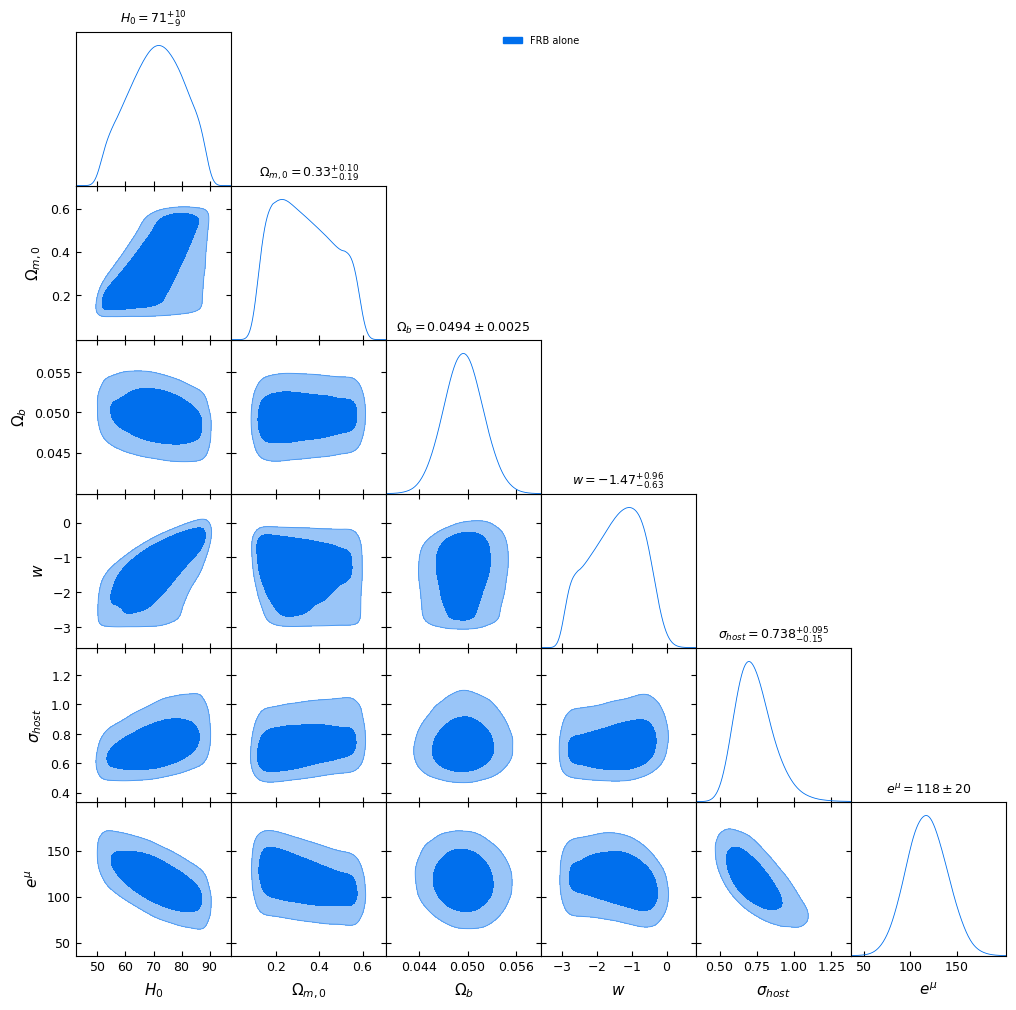

In [8]:
# =========================
# GetDist
# =========================

param_names  = ["H0", "Omega_m0", "Omega_b", "w", "sigma_host", "exp_mu"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b", r"w", r"\sigma_{host}", r"e^\mu"]

samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# samples.setRanges({
#     "H0": (50, 90),
#     "Omega_m": (0.1, 0.6)
# })

g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3

# Triangle plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["FRB alone"],
    #contour_colors=["#"],
    title_limit=1
)

plt.savefig("triangle_wCDM_frb.png", dpi=300, bbox_inches="tight")
plt.show()